In [2]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,110]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,110]']

PressFluc_bins = [0,3,6,9,12,15,20,35]
PFlucRange_labels = ['(0,3]','(3,6]','(6,9]','(9,12]','(12,15]','(15,20]','(20,35]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [3]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = ['COMPKEY']

    return waterMains


def getFailureRecords(numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {'WONO':'str', 'ACTCODE':'str','SERVNO':'str','SR_PROB':'str',
                                          'ADDDTTM':'str', 'COMPKEY':'int64'},
                                 index_col=0,
                                 parse_dates=['ADDDTTM'],
                                )[['SERVNO','ACTCODE','SR_PROB','ADDDTTM','COMPKEY']]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords['SR_PROB'].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords['ACTCODE'].isin(ACTCODERepair['ACTCODE'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords():

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {'WONO':'str', 'Street_Type':'str','Street_Name':'str','SUBURB':'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index('WONO', inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[['COMPKEY','Street_Type','Street_Name','SUBURB']]
    failAddr=failAddr.astype({'COMPKEY': 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on='COMPKEY')

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp['SUBURB'].str.upper()!=addrComp['Suburb'].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {'COMPKEY':'int64','STATUS':'str','MATERIAL':'str',
		                                         'NOM_DIA_MM':'str','INSTALLED':'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=['INSTALLED'],
		                                index_col=['COMPKEY']
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, 'STATUS': 'first', 'NOM_DIA_MM': 'first', 'MATERIAL' : 'first', 'INSTALLED':'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecords.index)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= 'COMPKEY').copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby(['COMPKEY']).agg({'SERVNO': 'count', 'ACTCODE' : 'first'})
    countNumFPerPipe.rename(columns={'SERVNO':'Num of failures'}, inplace= True)

    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGIS['NOM_DIA_MM'] = pd.to_numeric(wPipesGIS['NOM_DIA_MM'],errors='coerce')
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df['MATERIAL'] = df['MATERIAL'].replace(UNKNOWN, np.nan)
        df['NOM_DIA_MM'].fillna(0, inplace=True)

        #Combine AC
        df['MATERIAL'] = df['MATERIAL'].replace(FB, AC)

        #Combine PE
        df['MATERIAL'] = df['MATERIAL'].replace(ALK, PE)

        #combine CI
        df['MATERIAL'] = df['MATERIAL'].replace(CLCI, IRON)
        df['MATERIAL'] = df['MATERIAL'].replace(DI, IRON)
        df['MATERIAL'] = df['MATERIAL'].replace(ELCI, IRON)
        df['MATERIAL'] = df['MATERIAL'].replace(CLDI, IRON)
        df['MATERIAL'] = df['MATERIAL'].replace(GI, IRON)
        df['MATERIAL'] = df['MATERIAL'].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS



# -------------------------- UTILS ---------------------------------------------

In [4]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def setViolinAlpha(ax):
    
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)

# -------------------- CONST --------------------

In [5]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=['MATERIAL'])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=['DIAMETER'])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [6]:
fname = 'Data/03-WorkOrders.csv'
numFailureRecordsOri = 0

failureRecords , numFailureRecordsOri = getFailureRecords(numFailureRecordsOri)
ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

#divide between MAIN and SERViCE LINES------------------------------------------------
mainFailures = failureRecords[(failureRecords['ACTCODE']=='WMNRM') | (failureRecords['ACTCODE']=='WMNRPL')].copy()

numFailRecordsOriM = mainFailures.shape[0]

print('Number of failures in Mains :', numFailRecordsOriM)

addressFromFailureRecords = getAddressFromFailureRecords()
WMNFromAssetRecords = getAssetsRecords()

mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])


numFailRecordsOriM=mainFailures.shape[0]

#returns the shape_length in km
wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


In [7]:
#remove non predominan materials  and sort them 
predoMaterials = wPipesGISNfailures[wPipesGISNfailures['MATERIAL'].isin(MATERIALS_PREDOMI)].copy()
predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
predoMaterials=predoMaterials.sort_values('MATERIAL').copy()

failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS['MATERIAL'].isin(MATERIALS_PREDOMI)].copy()
failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
failuresPMaterials=failuresPMaterials.sort_values('MATERIAL').copy()

inService = predoMaterials[predoMaterials['STATUS'] == INSERV_PROCESS].copy()

failuresPMaterials["Age at failure"] = (pd.to_datetime(failuresPMaterials["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresPMaterials["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')

In [8]:
def getClimateData():

    fclimate='Data/Climate/00-ClimateInfoFinal.csv'

    climate = pd.read_csv(fclimate, delimiter = ',')
    
    climate= climate.replace('-', np.nan).copy()
    climate.loc[:,"Jan":"Dec"]= climate.loc[:,"Jan":"Dec"].astype(float,errors = 'raise').copy()

    climateTemp = climate[climate['Stats_Code']==2].copy()
    climateRainFall= climate[climate['Stats_Code']==0].copy()
    climateDefic= climate[climate['Stats_Code']==66].copy()
    
    return climateTemp,climateRainFall,climateDefic

In [9]:
def getPipesVsStations(df):
    
    fcliStaVsPipes='Data/Climate/05-WaterPipes_NearTablesClimate.txt'
    cliStaVsPipes = pd.read_csv(fcliStaVsPipes, delimiter = ',',usecols=[3,22,23,24,25],index_col=['COMPKEY'])
    #remove duplicate compkeys 
    cliStaVsPipes= cliStaVsPipes.groupby(cliStaVsPipes.index).agg({'Rain_Dist': 'first', 'Rain_ID': 'first',
                                                   'NEAR_FID': 'first', 'NEAR_DIST': 'first'}).copy()

    fcliStaTemp='Data/Climate/04-StationsTemperature.txt'
    cliStaTemp = pd.read_csv(fcliStaTemp, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaTemp.rename(columns={'Agent_Numb':'Station Temperature'},inplace=True)
    
    fcliStaRain='Data/Climate/03-StationsRain.txt'
    cliStaRain = pd.read_csv(fcliStaRain, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaRain.rename(columns={'Agent_Numb':'Station Rain'},inplace=True)
    
    pipesVsStations = df.join(cliStaVsPipes)
    
    pipesVsStations = pipesVsStations.join(cliStaTemp,on='NEAR_FID')
    pipesVsStations = pipesVsStations.join(cliStaRain,on='Rain_ID')
     
    assert pipesVsStations.shape[0] == df.shape[0]
    
    return pipesVsStations

#Gets a table of records failures columns values of the pipe and climate of the failure month
def getFailuresWithClimate(df, stationType, climateDf):
    
    columnsSel= ['ADDDTTM','NOM_DIA_MM','MATERIAL','Age at failure']

    fail= df[columnsSel + ['COMPKEY']].set_index("COMPKEY").copy()

    #Get the station of each pipe
    failNStations=getPipesVsStations(fail)[columnsSel + [stationType]].copy()
    failNStations.rename(columns={stationType:'Station'}, inplace= True)
    
    #Get the Year and failure month
    failNStations['Year ']= pd.to_datetime(failNStations['ADDDTTM']).dt.year
    failNStations['Failure month']= pd.to_datetime(failNStations['ADDDTTM']).dt.month
    
    #SEt the same index
    failNStations= failNStations.set_index(['Station' ,'Year '])
    clima= climateDf.set_index(['Station','Year ']).copy()
    
    #Join failures with climate
    failNClimate= failNStations.join(clima).copy()
    
    #Gets the month of the failure climate
    failNClimate["Month"]= failNClimate["Failure month"].apply(lambda x: calendar.month_abbr[x])
    failNClimate['ClimateAtFailure']= failNClimate.apply(lambda x: x[x['Month']],axis = 1)
    failNClimate=failNClimate[columnsSel+['ClimateAtFailure','Month']].copy()

    return failNClimate

def getClimateGraph(df,Station,climateDf,labelStat,LF,leng):

    df=getFailuresWithClimate(df,Station,climateDf)

    dfGrouped = df.groupby(['MATERIAL',"Year ","Month"]).agg({'ADDDTTM':'count', 'ClimateAtFailure':'mean'})

    dfPlot= dfGrouped.reset_index().copy()
    
    dfPlot = dfPlot.join(leng,on="MATERIAL")
    dfPlot['Failure rate (Failures/km/month)']= dfPlot['ADDDTTM']/dfPlot['Shape_Leng']
    
    
    dfPlot= dfPlot.dropna(subset=['ClimateAtFailure']).copy()
    
    print("Using ", dfPlot.shape[0], " records")

    g= sns.lmplot(data=dfPlot, x='ClimateAtFailure', y="Failure rate (Failures/km/month)", hue="MATERIAL", palette=pal,
                         height=7,aspect=1.5,legend_out=False)  

    plt.legend(ncol=6, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))
    g.axes[0][0].grid(axis='y', which='both')
    sns.despine(left=True)
    
    g.axes[0][0].set_xlabel(labelStat)
    #g.axes[0][0].set_ylabel("Failure rate (Failures/km/month)")
    
    regs = getRegressionValues(dfPlot,LF)
    
    regsDF= pd.DataFrame(regs, columns = ['Material', 'Slope','Intercept', 'Std_dev', 'P_value',
                                         'Rsquared'])
    
    regsDF.to_csv("Output/Regressions/Climate"+LF+"Table"+".csv")
    
    return g.fig


In [26]:
def getRegressionValues(Df,LF):
    
    regres= []
    
    #text_file = open("Output/Regressions/Climate"+LF+".csv", "w")
    
    for m in MATERIALS_PREDOMI:
        
        DfMAT= Df[Df["MATERIAL"]==m].sort_values(by='ClimateAtFailure', ascending=True).copy()
        
        X= DfMAT['ClimateAtFailure'].copy()
        y= DfMAT['Failure rate (Failures/km/month)'].copy()
          
        X = sm.add_constant(X)
        
        #model = sm.Poisson(y, X).fit() #OLS for linear 
        #text_file.write(model.summary(title=m).as_csv())
           
        model = sm.OLS(y, X).fit() 

        #material, slope, intercept, std dev, p-value of the slope, rsquared
        regres.append([m,model.params['ClimateAtFailure'], model.params['const'], 
                           model.bse['ClimateAtFailure'], model.pvalues['ClimateAtFailure'], model.rsquared])

    
    #text_file.close()
    return regres
  

In [22]:
def getClimateFailuresGraphs(dfFailures,pipes):
    
    climateTemp,climateRainFall,climateDefic= getClimateData()
    pipeLeng= pipes.groupby(['MATERIAL']).agg({'Shape_Leng':sum }).copy()
    
    for lab,df,sta,lF in zip(['Mean air temperature (C)','Total rainfall (mm)','Mean soil moisture deficit (mm)'],
                      [climateTemp,climateRainFall,climateDefic],
                      ['Station Temperature','Station Rain','Station Rain'],
                         ["Temp","Rain","SMD"]):
    
        fig = getClimateGraph(dfFailures.copy(),sta,df,lab,lF,pipeLeng) 
        
        fig.savefig('Maps_Graph/ClimateAnalysis/'+'FailuresMonth' +lF +'.png', dpi=200, bbox_inches='tight')


Using  288  records
Using  288  records
Using  288  records


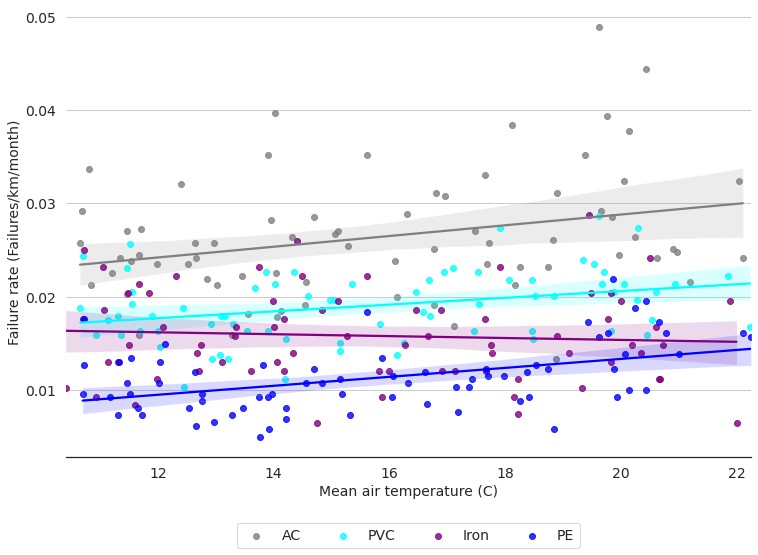

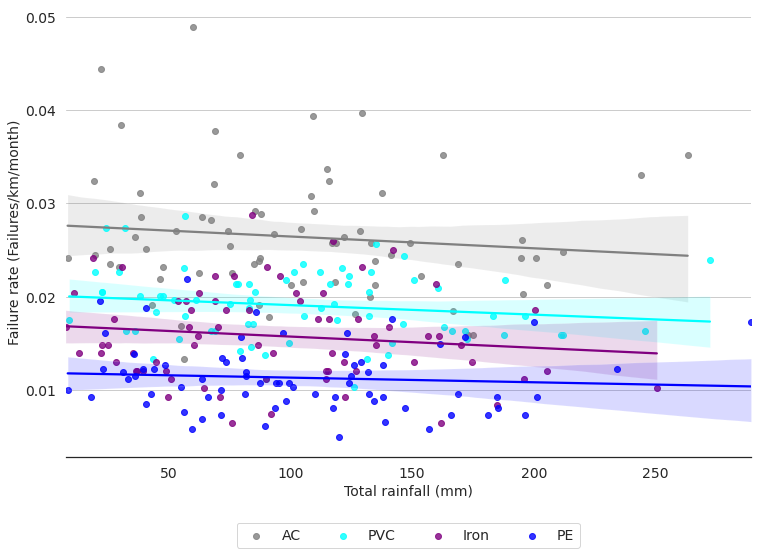

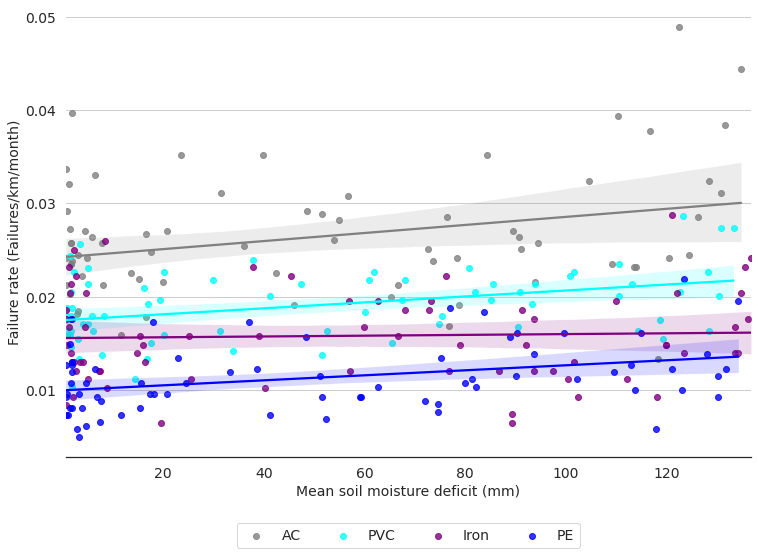

In [27]:
getClimateFailuresGraphs(failuresPMaterials.copy(),predoMaterials.copy())

Using  288  records
Optimization terminated successfully.
         Current function value: 5.399932
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.585908
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.115288
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.720883
         Iterations 4
Using  288  records
Optimization terminated successfully.
         Current function value: 5.587724
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.651848
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.105170
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.002918
         Iterations 5
Using  288  records
Optimization terminated successfully.
         Current function value: 5.383312
         Iterations 4
Optimization terminate

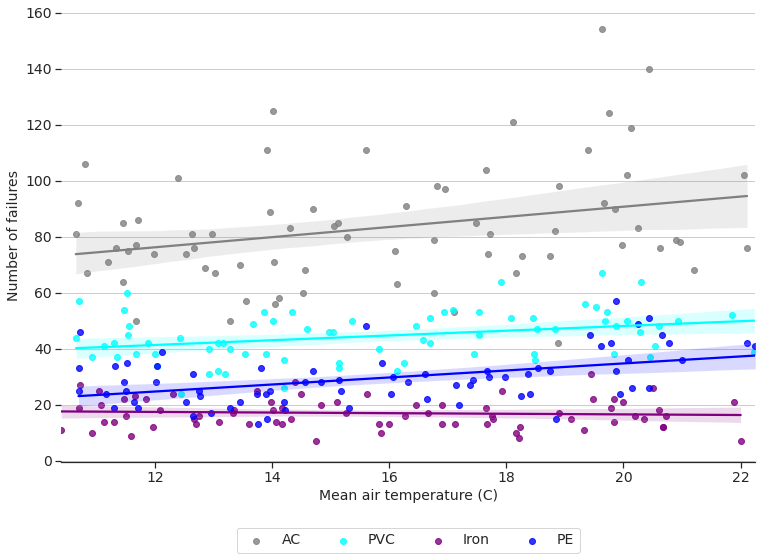

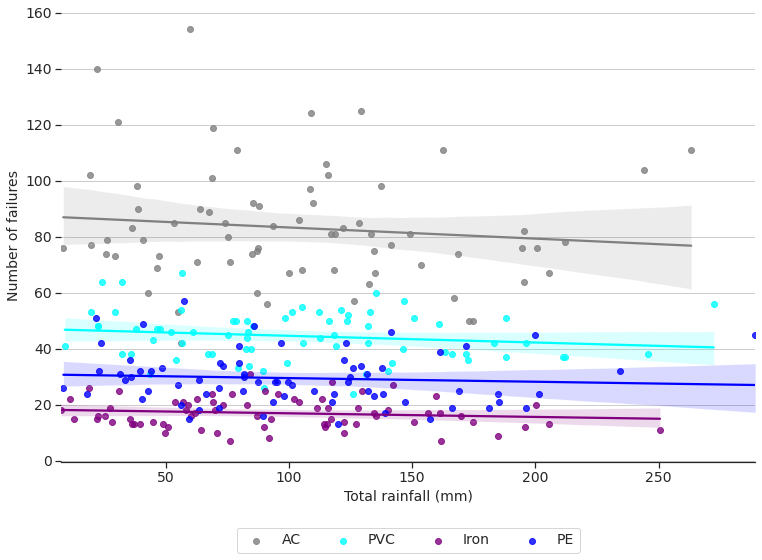

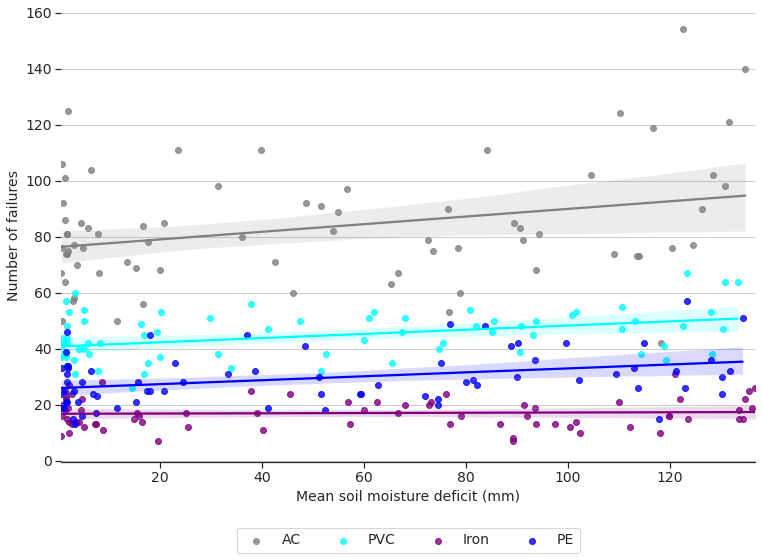

In [39]:
getClimateFailuresGraphs(failuresPMaterials.copy())

In [55]:
def getPipeLengthPerStation(inSerWithStations):
    
    pipelengPerStationRain = inSerWithStations.groupby(['Station Rain']).agg({'Shape_Leng':sum}).sort_values(by='Shape_Leng',ascending=False).copy()
    pipelengPerStationTemp = inSerWithStations.groupby(['Station Temperature']).agg({'Shape_Leng':sum}).sort_values(by='Shape_Leng',ascending=False).copy()

    pipelengPerStationRain['%']= pipelengPerStationRain['Shape_Leng']/pipelengPerStationRain['Shape_Leng'].sum()*100
    pipelengPerStationTemp['%']= pipelengPerStationTemp['Shape_Leng']/pipelengPerStationTemp['Shape_Leng'].sum()*100
    
    fig1, (ax, ax2)  = plt.subplots(2,figsize=(14,6))

    ax = pipelengPerStationRain[['%']].plot.bar( ax= ax, rot=-20)
    
    ax2 = pipelengPerStationTemp[['%']].plot.bar( ax= ax2, color='indianred', rot=-20)


    #styling
    ax = removeTopRightFrame(ax)
    ax2 = removeTopRightFrame(ax2)
    ax.set_xlabel('')
    ax2.set_xlabel('Stations id')
    ax.legend(["Rain & Soil moisture deficit"],fontsize=14)
    ax2.legend(["Air temperature"],fontsize=14)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax2.set_yticks([])
    plt.subplots_adjust(hspace = .3)

    for bar in ax.patches:
        ax.text(bar.get_x() + bar.get_width() / 2,bar.get_height()+0.005,int(bar.get_height()),
                horizontalalignment='center')
    for bar in ax2.patches:
        ax2.text(bar.get_x() + bar.get_width() / 2,bar.get_height()+0.005,int(bar.get_height()),
                horizontalalignment='center')

    fig1.text(0.09, 0.5, '% pipe length associated', va='center', rotation='vertical');

    fig1.savefig('Maps_Graph/ClimateAnalysis/'+'PipeLengthPerStation' +'.png', dpi=200, bbox_inches='tight')

def getDistancesGraph(df):
    
    fig1, (ax, ax2)  = plt.subplots(2,figsize=(10,3),sharex=True)

    ax= sns.kdeplot(x="Rain_Dist",  data=df, ax=ax,cut=0,alpha=.5,weights="Shape_Leng",fill=True, linewidth=2)
    ax2= sns.kdeplot(x="NEAR_DIST",  data=df, ax=ax2,color='r',cut=0,alpha=.5,weights="Shape_Leng",fill=True, linewidth=2)

    ax = removeTopRightFrame(ax)
    ax2 = removeTopRightFrame(ax2)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax2.set_yticks([])

    ax.set_xlabel('')
    ax2.set_xlabel('Station-pipe distance (m)')
    ax.set_ylabel('Rain & \n Soil moisture deficit',rotation=0,ha='right',va="top")
    ax2.set_ylabel('Air \n Temperature',rotation=0,ha='right',va="top")
     
    fig1.savefig('Maps_Graph/ClimateAnalysis/'+'StationDistanceToPipe' + '.png', dpi=200, bbox_inches='tight')


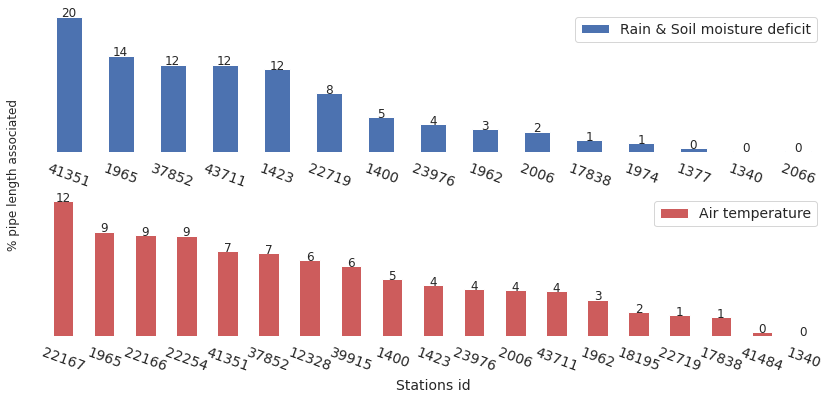

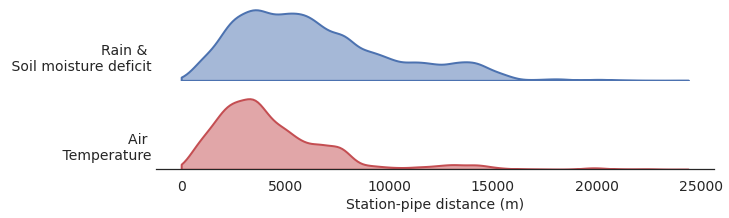

In [56]:
def getInServicePipesDistOfClimateStations(inServiceP):
    
    #predominant materials and in service
    pipesNStations= getPipesVsStations(inServiceP)
   
    getPipeLengthPerStation(pipesNStations)
    
    getDistancesGraph(pipesNStations)
    
    return pipesNStations

a=getInServicePipesDistOfClimateStations(inService.copy())

In [56]:
def getClimatePerMonth(df,col):
    
    df=df.drop(columns=['Annual']).copy()
    df=df.melt(id_vars=['Station','Year '], value_vars=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']).copy()
    df.rename(columns={'value': col,'variable':'Month'}, inplace= True)
    
    return df


def getSummaryStationsPlot(df, col):

    df=getClimatePerMonth(df,col)

    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = sns.lineplot(x="Month", y=col,  hue="Year ", data=df,ax=ax, palette=sns.color_palette("husl"))
    ax.grid(axis='y', which='both')
    ax.legend(ncol=6, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))

    sns.despine(left=True)
    
    return fig1

def getSummaryStationsPlots(inServiceP):
    
    climateTemp,climateRainFall,climateDefic= getClimateData()
    
    inSerWithStations = getPipesVsStations(inServiceP)
    
    for col,df,typeStat,sta in zip(['Mean Air Temperature (C)','Total rainfall (mm)','Mean soil moisture deficit (mm)'],
                      [climateTemp,climateRainFall,climateDefic],['Station Temperature','Station Rain','Station Rain'],
                     ['Temp','Rain','Moisture']):

        
        dfClimate= df[df['Station'].isin(inSerWithStations[typeStat])].copy()
        
        #display(dfClimate['Station'].unique().tolist())
        
        fig = getSummaryStationsPlot(dfClimate.copy(), col)

        fig.savefig('Maps_Graph/ClimateAnalysis/'+'Summary' + sta +'.png', dpi=200, bbox_inches='tight')


[12328,
 1340,
 1400,
 1423,
 17838,
 18195,
 1962,
 1965,
 2006,
 22166,
 22167,
 22254,
 22719,
 23976,
 37852,
 41351,
 41484,
 39915,
 43711]

[1340,
 1377,
 1400,
 1423,
 17838,
 1962,
 1965,
 1974,
 2006,
 2066,
 22719,
 37852,
 41351,
 23976,
 43711]

[1340,
 1377,
 1400,
 1423,
 17838,
 1962,
 1965,
 1974,
 2006,
 2066,
 22719,
 37852,
 41351,
 23976,
 43711]

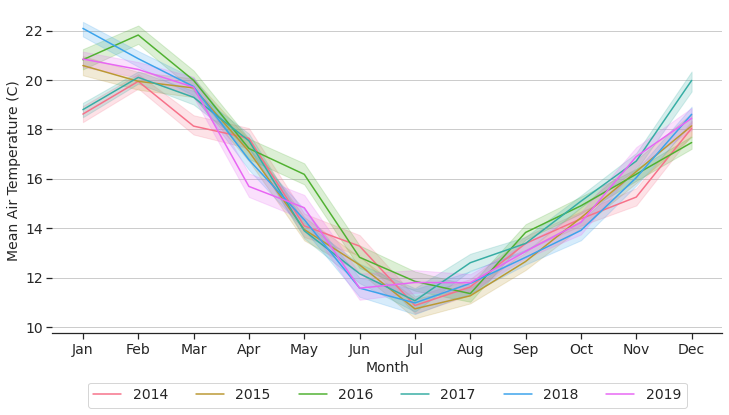

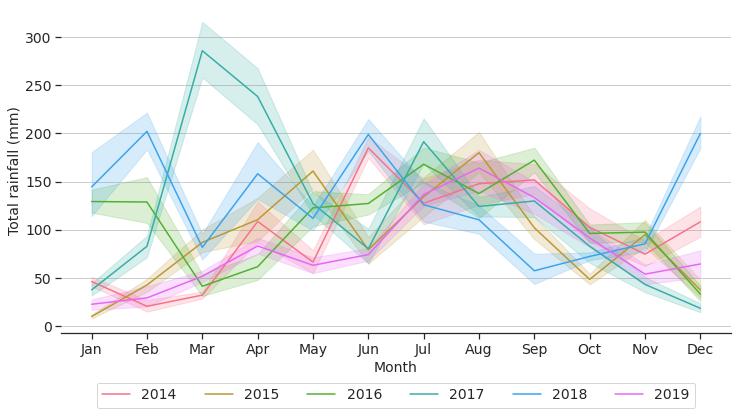

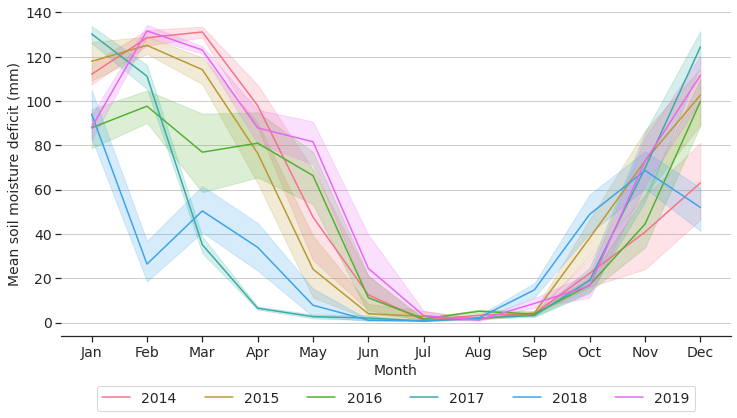

In [57]:
getSummaryStationsPlots(inService.copy())

In [47]:
sns.set_style("white")

# Utils ---------------------------

In [17]:
def getAucklandStations():

    fAllClimateStations='Data/Climate/02-StationsInfo.csv'

    allClimateStations = pd.read_csv(fAllClimateStations, delimiter = ',')

    return allClimateStations


def getStationsName(df):
    
    fcliStaTemp='Data/Climate/04-StationsTemperature.txt'
    cliStaTemp = pd.read_csv(fcliStaTemp, delimiter = ',',usecols=[0,2,3,12],index_col=['FID'])

    fcliStaRain='Data/Climate/03-StationsRain.txt'
    cliStaRain = pd.read_csv(fcliStaRain, delimiter = ',',usecols=[0,2,3,12],index_col=['FID'])

    stationsInfo = cliStaTemp.append(cliStaRain)

    stationsUsed = df['Rain_ID'].unique().tolist() + df['NEAR_FID'].unique().tolist()

    staNames = stationsInfo[stationsInfo.index.isin(stationsUsed)].copy().drop_duplicates()

    staNames.sort_values(by='Agent_Numb')[['Agent_Numb','Name']]
    
    return staNames

# Utils finish---------------------------------------------------------------

# From base analysis ------------------------------------------------------------------

In [79]:
def getNumFailuresPerMonth(failuresPMaterials):
    
    #Get a table with the number of failures per month in the 6 years segregated by material
    failuresPMaterials['Failure year']= pd.to_datetime(failuresPMaterials['ADDDTTM']).dt.year
    failuresPMaterials['Failure month']= pd.to_datetime(failuresPMaterials['ADDDTTM']).dt.month

    failureGroupMonthly=failuresPMaterials.groupby(['MATERIAL',"Failure year","Failure month"]).agg({'Shape_Leng':sum, 'ADDDTTM':'count'})

    failureGroupMonthly.rename(columns={'ADDDTTM':'Number of failures'},inplace=True)
    failureGroupMonthly=failureGroupMonthly.reset_index()
    failureGroupMonthly["Month"]= failureGroupMonthly["Failure month"].apply(lambda x: calendar.month_abbr[x])
    
    return failureGroupMonthly
    
    

# FRom regression analysis ----------------------------------------------------------

In [11]:
def joinWithClimate(dfPipes):
    
    climateVals= getClimateData()
    
    #Get the station of each pipe
    dfPipesS=getPipesVsStations(dfPipes).copy()
    dfPipesS.drop(['Rain_Dist','Rain_ID','NEAR_FID','NEAR_DIST'], axis=1, inplace=True)
    assert dfPipesS.shape[0] == dfPipes.shape[0]
    
    for climate, sta,v in zip(climateVals,['Station Temperature','Station Rain','Station Rain'],
                             ["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"]):
       
        cli=climate.rename(columns={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8,
                                'Sep':9,'Oct':10,'Nov':11,'Dec':12, 'Station': sta,'Year ':"Year"})

        cli=cli.drop(['Stats_Code','Annual'], axis=1).set_index([sta,'Year']).copy()
        
        cli[v]= cli.max(axis=1)-cli.min(axis=1)
        cli= cli.reset_index().groupby([sta]).agg({v:'mean'}).copy()
        
        #Join pipes with climate
        dfPipesS= dfPipesS.join(cli, on=sta).copy()
        assert dfPipes.shape[0] == dfPipesS.shape[0]
        
    dfPipesS.drop(['Station Temperature','Station Rain'], axis=1,inplace=True)
    
    dfPipesS.dropna(inplace=True)
    
    print("After cleaning Climate ", dfPipesS.shape[0])

    return dfPipesS



# End from regression ----

In [33]:
def getRegressionValues(Df):
    
    for v in ["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"]:
        
        regres= []
        
        for m in MATERIALS_PREDOMI:
        
            DfMAT= Df[Df["MATERIAL"]==m].copy()

            X= DfMAT[v].copy()
            y= DfMAT['Failure rate (Failures/km/year)'].copy()
            w= DfMAT['Shape_Leng'].copy()

            X = sm.add_constant(X)

            model = sm.WLS(y, X,w).fit() 

            #material, slope, intercept, std dev, p-value of the slope, rsquared
            regres.append([m,model.params[v], model.params['const'], 
                               model.bse[v], model.pvalues[v], model.rsquared])

        df=pd.DataFrame(regres, columns =[v, 'Slope', 'Intercept', 
                                      'Std dev', 'Slope P-value', 'Rsquared'])
        display(df)
    

In [27]:
pipesWithClimate=joinWithClimate(predoMaterials.copy())
pipesWithClimate['Failure rate (Failures/km/year)'] = pipesWithClimate['Num of failures']/pipesWithClimate['Shape_Leng']/6

After cleaning Climate  198694


In [34]:
getRegressionValues(pipesWithClimate.copy())

,Temp M(max-min),Slope,Intercept,Std dev,Slope P-value,Rsquared
0,AC,0.004809,0.273123,0.005281,0.362456,0.000014
1,PVC,-0.027197,0.487305,0.008437,0.001267,0.000240
2,Iron,0.009157,0.116908,0.004488,0.041347,0.000126
3,PE,-0.013594,0.263879,0.006515,0.036922,0.000068


,Rain M(max-min),Slope,Intercept,Std dev,Slope P-value,Rsquared
0,AC,0.001908,-0.006551,0.000367,2.099130e-07,0.000461
1,PVC,0.001368,-0.000434,0.000373,2.459530e-04,0.000311
2,Iron,0.001507,-0.066240,0.001039,1.467542e-01,0.000064
3,PE,0.000343,0.077934,0.000349,3.258716e-01,0.000015


,SMD M(max-min),Slope,Intercept,Std dev,Slope P-value,Rsquared
0,AC,0.000516,0.254436,0.000843,5.403515e-01,0.000006
1,PVC,0.003885,-0.239507,0.000880,1.008464e-05,0.000451
2,Iron,0.005205,-0.454175,0.002577,4.343431e-02,0.000123
3,PE,0.006512,-0.640449,0.000856,2.803206e-14,0.000905


In [29]:
MATERIALS_PREDOMI

['AC', 'PVC', 'Iron', 'PE']

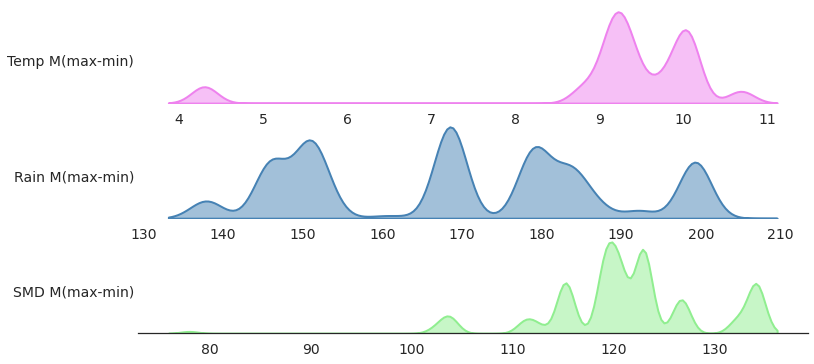

In [20]:
fig1, [ax,ax1,ax2]  = plt.subplots(3,figsize=(12,6))

for axA,v,c in zip([ax,ax1,ax2],
                ["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"],
                ['violet','steelblue','lightgreen']):
    
    axA= sns.kdeplot(x=v,  data=pipesWithClimate, ax=axA,alpha=.5,weights="Shape_Leng",fill=True, linewidth=2,color=c)
    
    axA = removeTopRightFrame(axA)
    
    axA.spines['left'].set_visible(False)
    axA.set_yticks([])
    axA.set_xlabel('')
    axA.set_ylabel(v,rotation=0,ha='right',va="top")
   
    if axA is not ax2:
        axA.spines['bottom'].set_visible(False)
    
    


In [ ]:
def getMaterialDisClimate(df):
    
    for v,l in zip(["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"],["Temp","Rain","SMD"]):
        
        v_bins = 
        v_labels = 
    
        dfGroup= groupByFactor(df,v+"R",v,v_bins,v_labels,None,None,None)
    
        fig1= getMaterialColRangeDis(dfGroup,v+"R")
        fig1.savefig('Maps_Graph/ClimateAnalysis/'+'MaxMinDistribution'+l +'.png', dpi=200, bbox_inches='tight')

